In [1]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# sets the global parameters for Scanpy (全局参数)

# 0: no log output.
# 1: basic information
# 2: Additional information
# 3: detailed inofrmation
sc.settings.verbosity = 0

# for plots
sc.settings.set_figure_params(dpi=80, facecolor="white")

### 1. Load the data

In [3]:
adata = sc.datasets.pbmc3k()
print(adata)

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


### 2. Quality Control

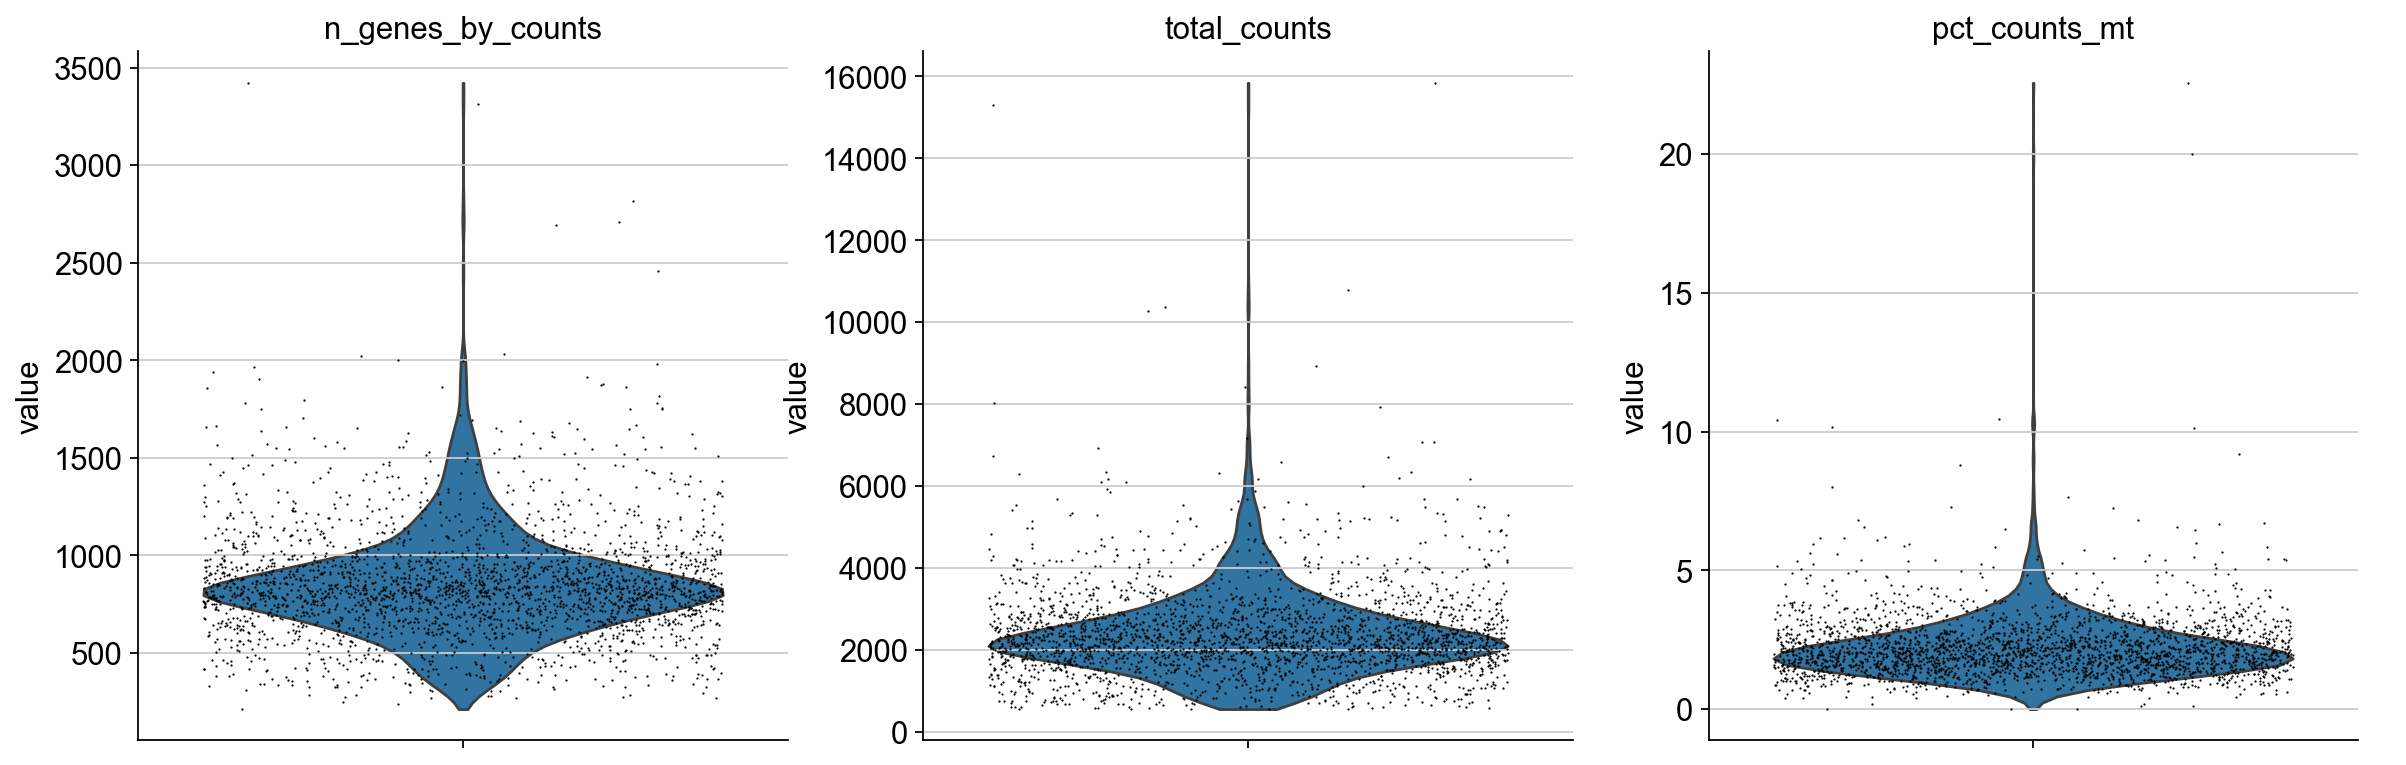

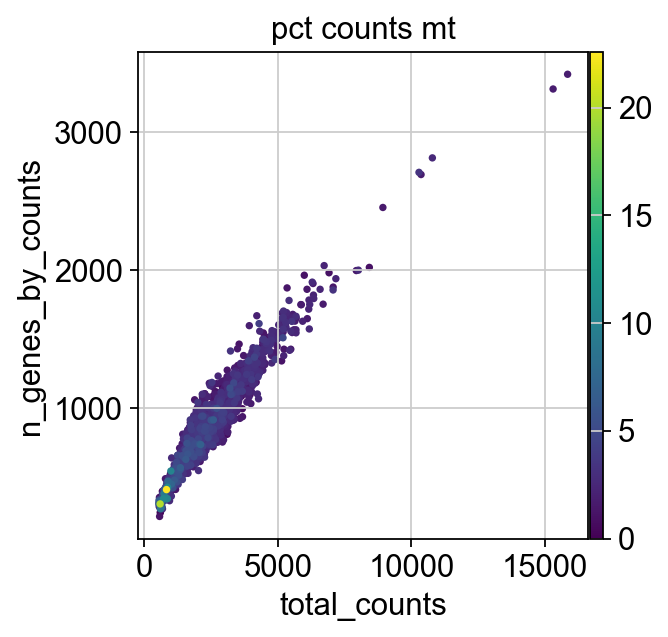

In [4]:
# Check which genes in the dataset are mitochondrial genes.
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, log1p=True
)

# Draw the violin plots to check the distribution.
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


In [5]:
# Filtering
adata = adata[
    (adata.obs["total_counts"] > 500) & 
    (adata.obs["total_counts"] < 15000) & 
    (adata.obs["n_genes_by_counts"] > 200) & 
    (adata.obs["n_genes_by_counts"] < 3000) & 
    (adata.obs["pct_counts_mt"] < 20),
    :
]

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")


Number of cells after filtering of low quality cells: 2696


In [6]:
# Detection Doublet
adata = adata.copy() # To aviod ImplicitModificationWarning
sc.pp.scrublet(adata)

# Remove Doublet
adata = adata[adata.obs["doublet_score"] < 0.2, :]

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")


Number of cells after filtering of low quality cells: 2647


### 3. Normalization

Text(0.5, 0, 'Total Counts')

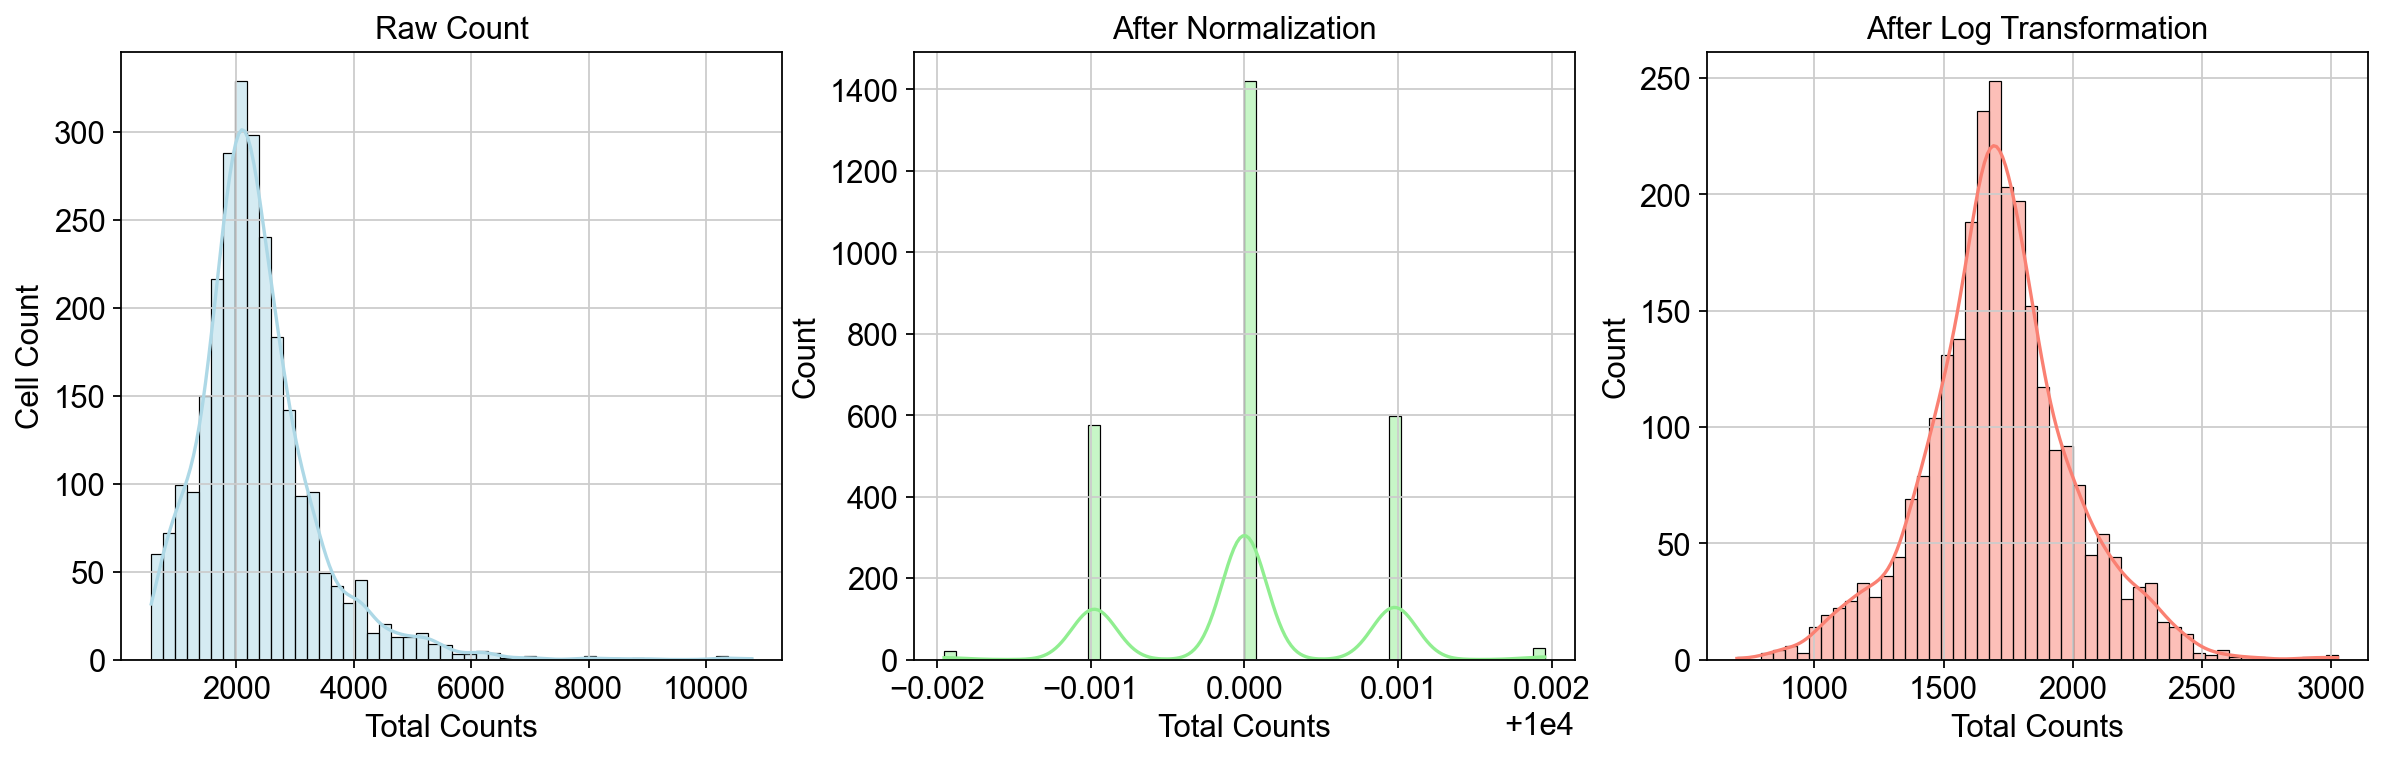

In [7]:
adata = adata.copy() # To aviod ImplicitModificationWarning

# raw
adata.obs["total_counts_raw"] = adata.X.sum(axis=1)

# Normalization
sc.pp.normalize_total(adata, target_sum=1e4) # Usually choose 1e4, which is 10000 counts
adata.obs["total_counts_norm"] = adata.X.sum(axis=1)

# log transformation
sc.pp.log1p(adata)
adata.obs["total_counts_log"] = adata.X.sum(axis=1)

adata.raw = adata

# draw plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# raw data
sns.histplot(adata.obs["total_counts"], bins=50, kde=True, ax=axes[0], color="lightblue")
axes[0].set_title("Raw Count")
axes[0].set_xlabel("Total Counts")
axes[0].set_ylabel("Cell Count")

# after normalization
sns.histplot(adata.obs["total_counts_norm"], bins=50, kde=True, ax=axes[1], color="lightgreen")
axes[1].set_title("After Normalization")
axes[1].set_xlabel("Total Counts")

# after transformation
sns.histplot(adata.obs["total_counts_log"], bins=50, kde=True, ax=axes[2], color="salmon")
axes[2].set_title("After Log Transformation")
axes[2].set_xlabel("Total Counts")


### 4. Feature Selection

/Users/gloriasong/anaconda3/envs/single_cell_env/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:75: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


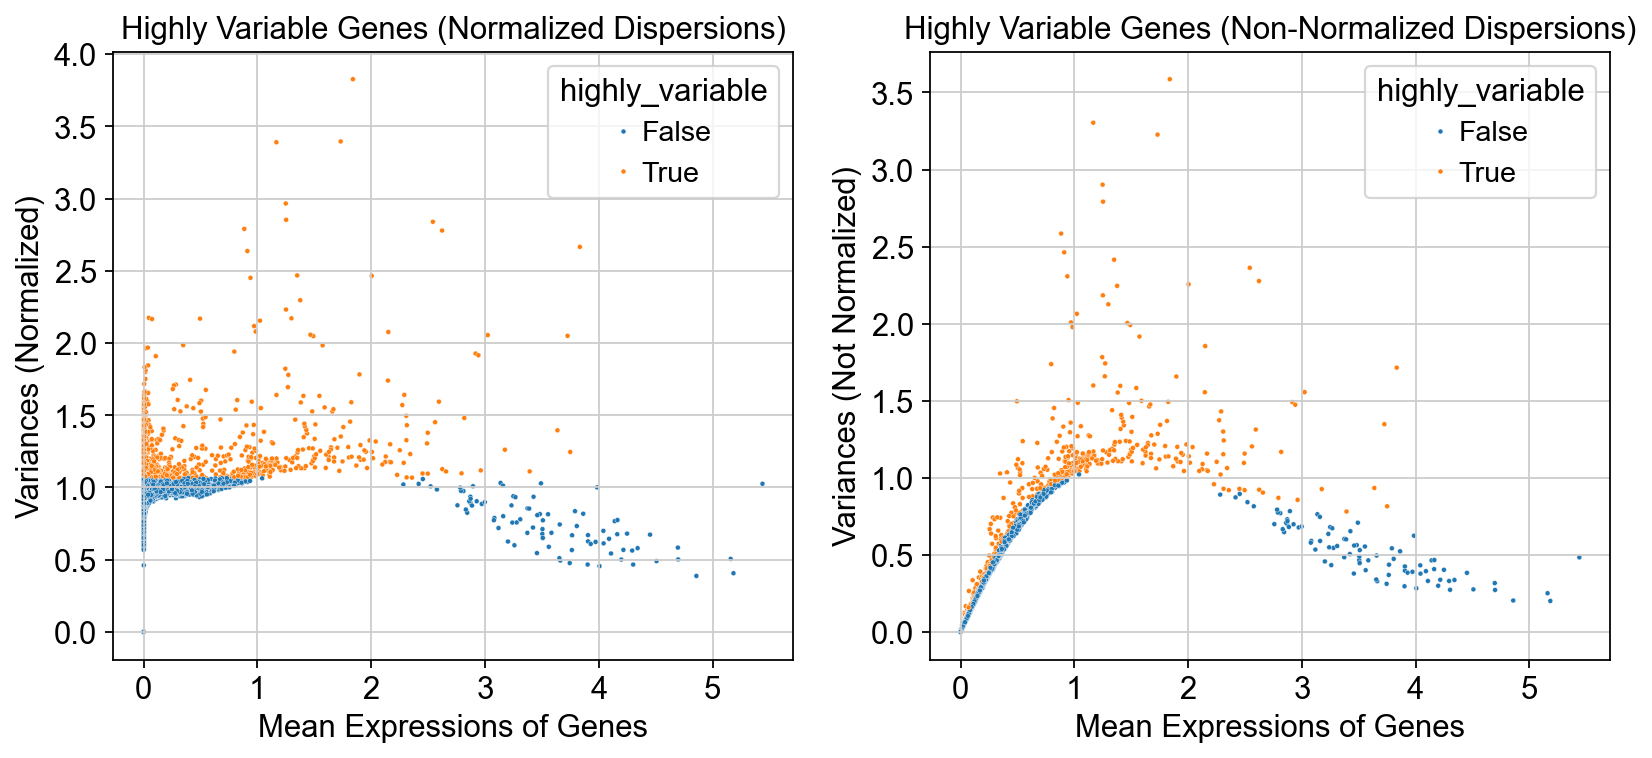

View of AnnData object with n_obs × n_vars = 2647 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'total_counts_raw', 'total_counts_norm', 'total_counts_log'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'scrublet', 'log1p', 'hvg'


In [8]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(
    data=adata.var, 
    x="means", 
    y="variances_norm", 
    hue="highly_variable", 
    s=5,
    ax=axes[0]
)
axes[0].set_title("Highly Variable Genes (Normalized Dispersions)")
axes[0].set_xlabel("Mean Expressions of Genes")
axes[0].set_ylabel("Variances (Normalized)")

sns.scatterplot(
    data=adata.var, 
    x="means", 
    y="variances", 
    hue="highly_variable", 
    s=5,
    ax=axes[1]
)

axes[1].set_title("Highly Variable Genes (Non-Normalized Dispersions)")
axes[1].set_xlabel("Mean Expressions of Genes")
axes[1].set_ylabel("Variances (Not Normalized)")


plt.show()
# filtering low variable genes
adata = adata[:, adata.var["highly_variable"]]
print(adata)

### 5. Dimensionality Reduction

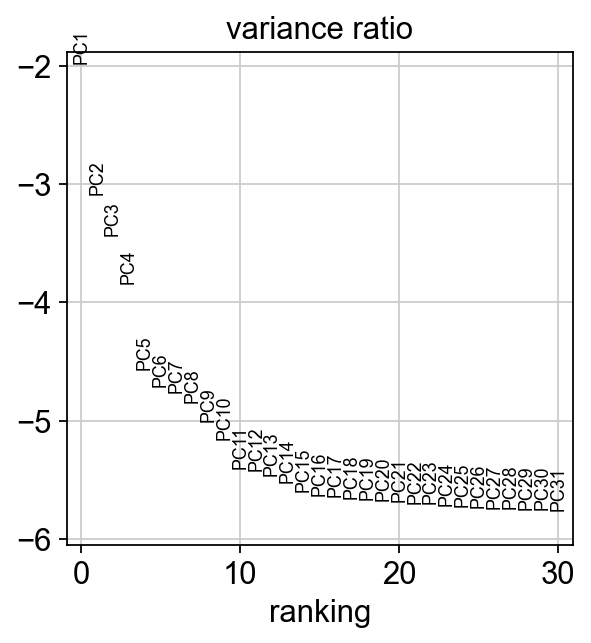

In [9]:
adata = adata.copy() # To aviod ImplicitModificationWarning

# Compute PCA
sc.tl.pca(adata) # defalut to 50 dimension 
sc.pl.pca_variance_ratio(adata, log=True) # Usually choose 10-50 PCs

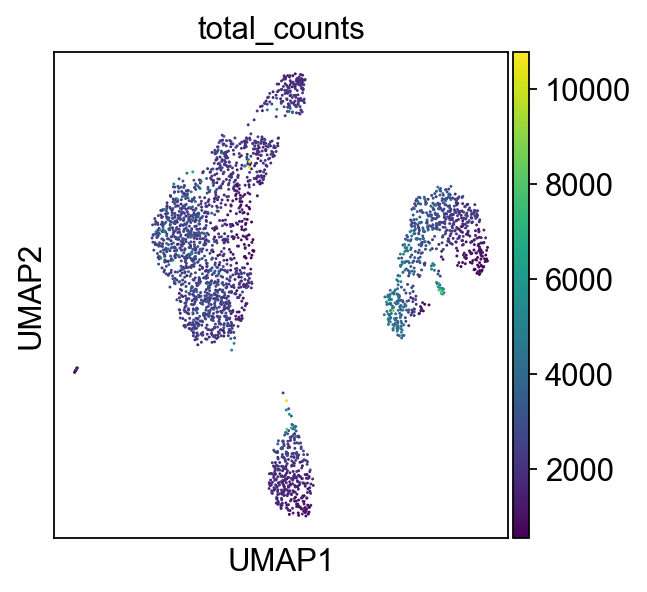

In [10]:
# neighborhood graph
sc.pp.neighbors(adata, n_pcs=15)

sc.tl.umap(adata)

# visualize
sc.pl.umap(adata, color="total_counts", size=7)

### 6. Clustering

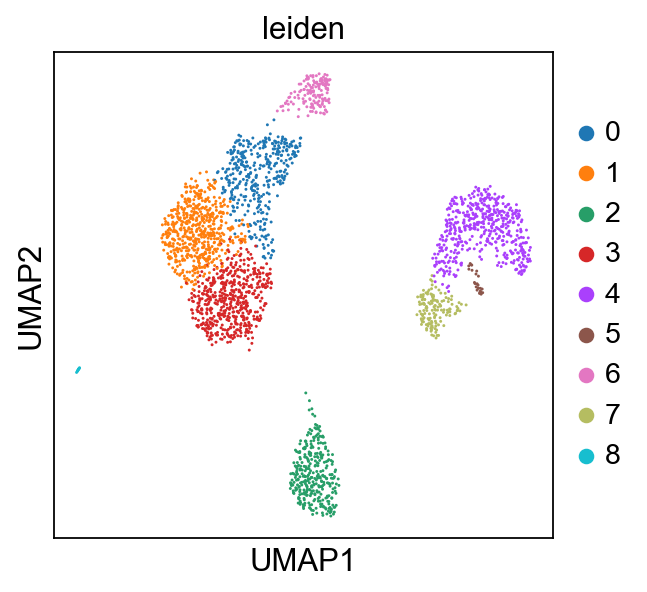

In [11]:
sc.tl.leiden(adata, flavor="igraph",
             n_iterations=2, resolution=0.5)
sc.pl.umap(adata, color=["leiden"], size=7)

/var/folders/9r/ldn3_2nx38dgrcfn9qqssncm0000gn/T/ipykernel_67264/1598666590.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="leiden_res_0.02", resolution=0.02)


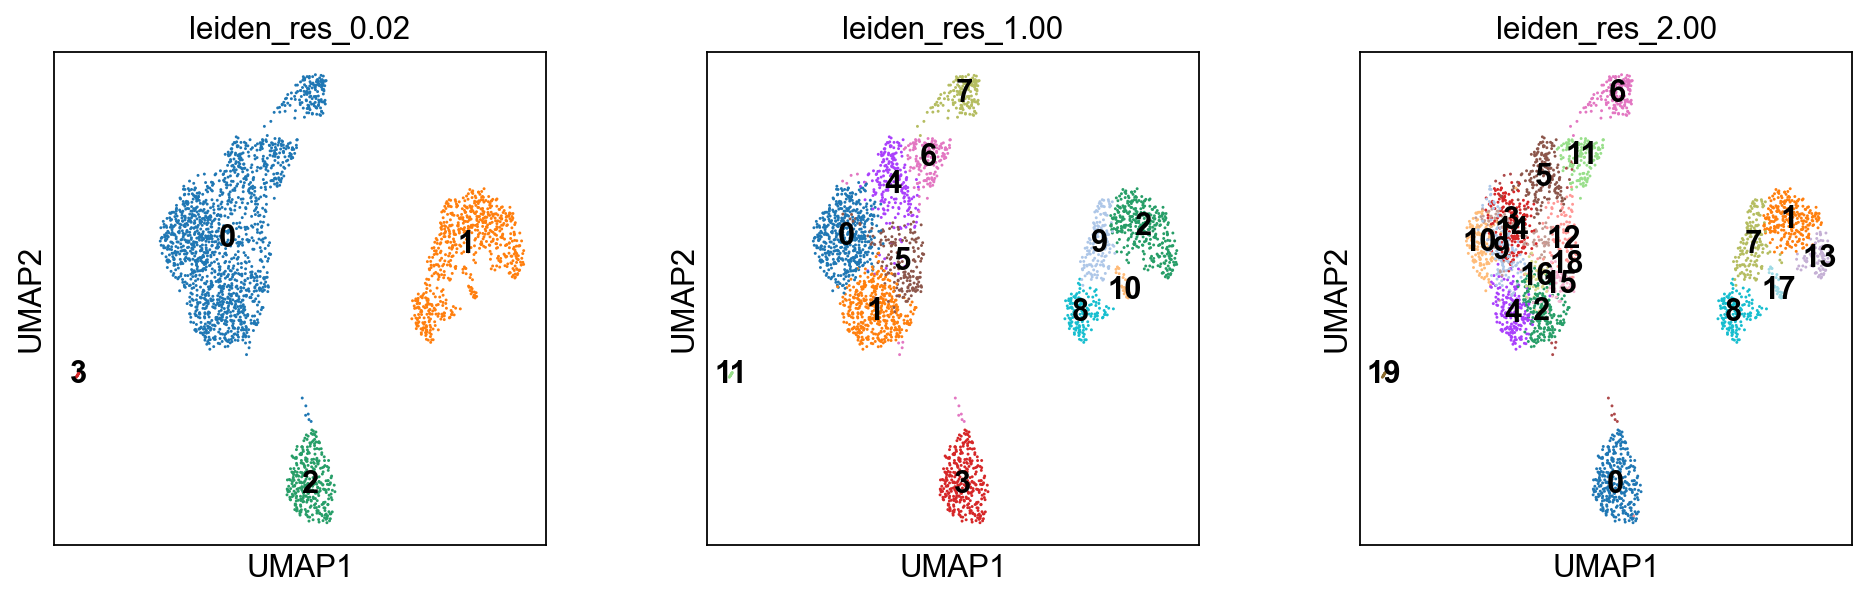

In [12]:
# compare difference resolution
sc.tl.leiden(adata, key_added="leiden_res_0.02", resolution=0.02)
sc.tl.leiden(adata, key_added="leiden_res_1.00", resolution=1.0)
sc.tl.leiden(adata, key_added="leiden_res_2.00", resolution=2.0)

sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_1.00", "leiden_res_2.00"],
    legend_loc="on data",
    size=7,
)

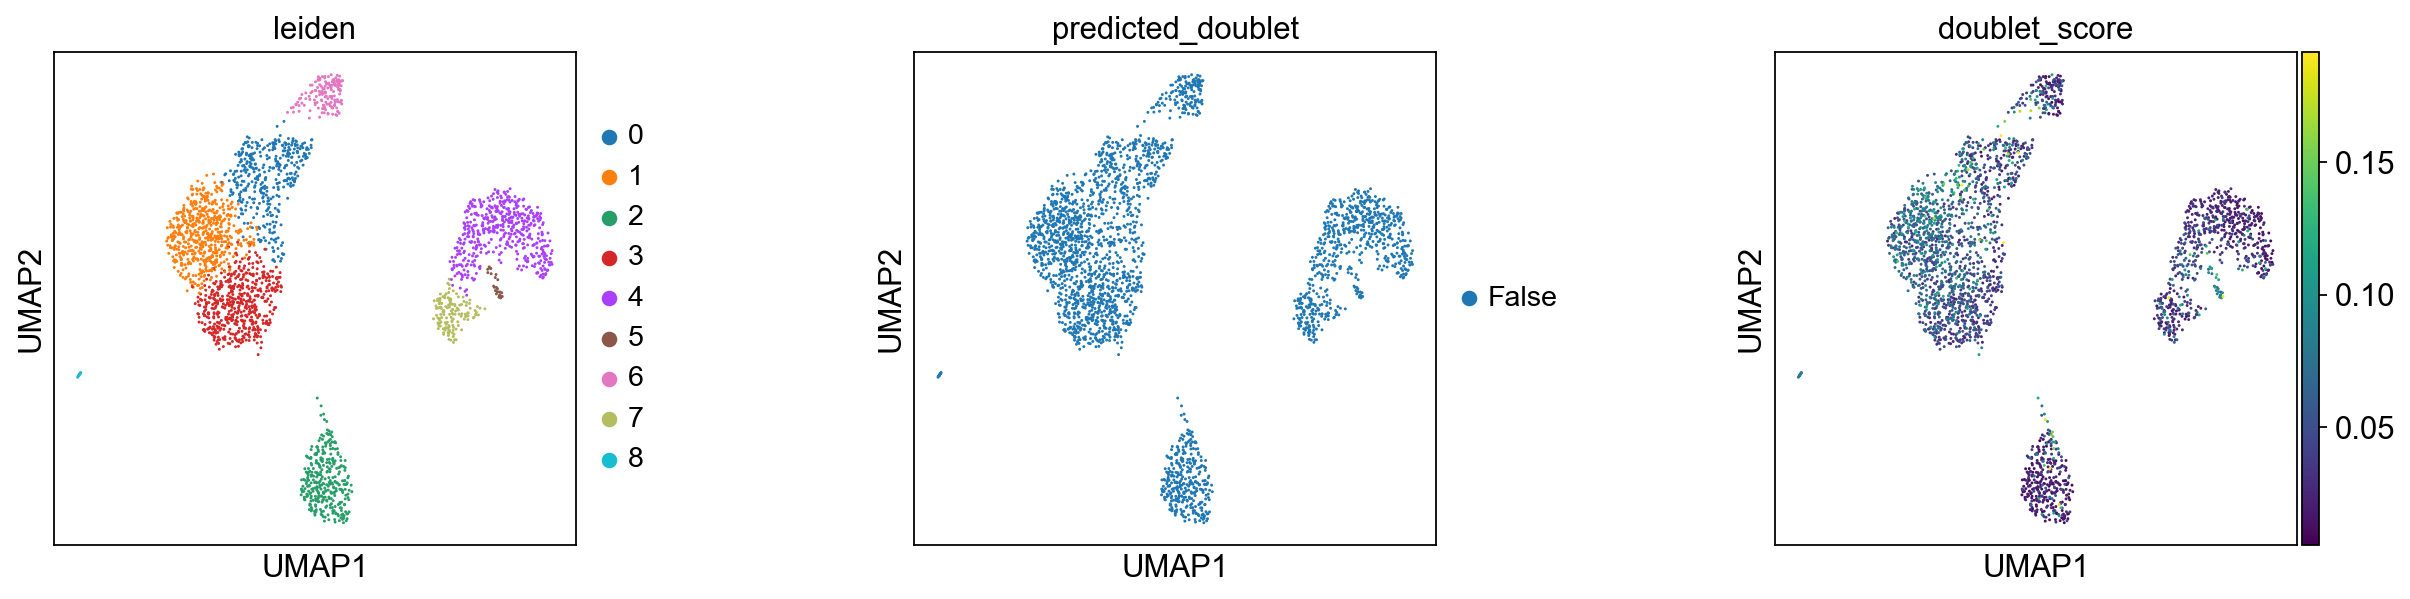

In [13]:
# Re-assess quality control
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=7,
)

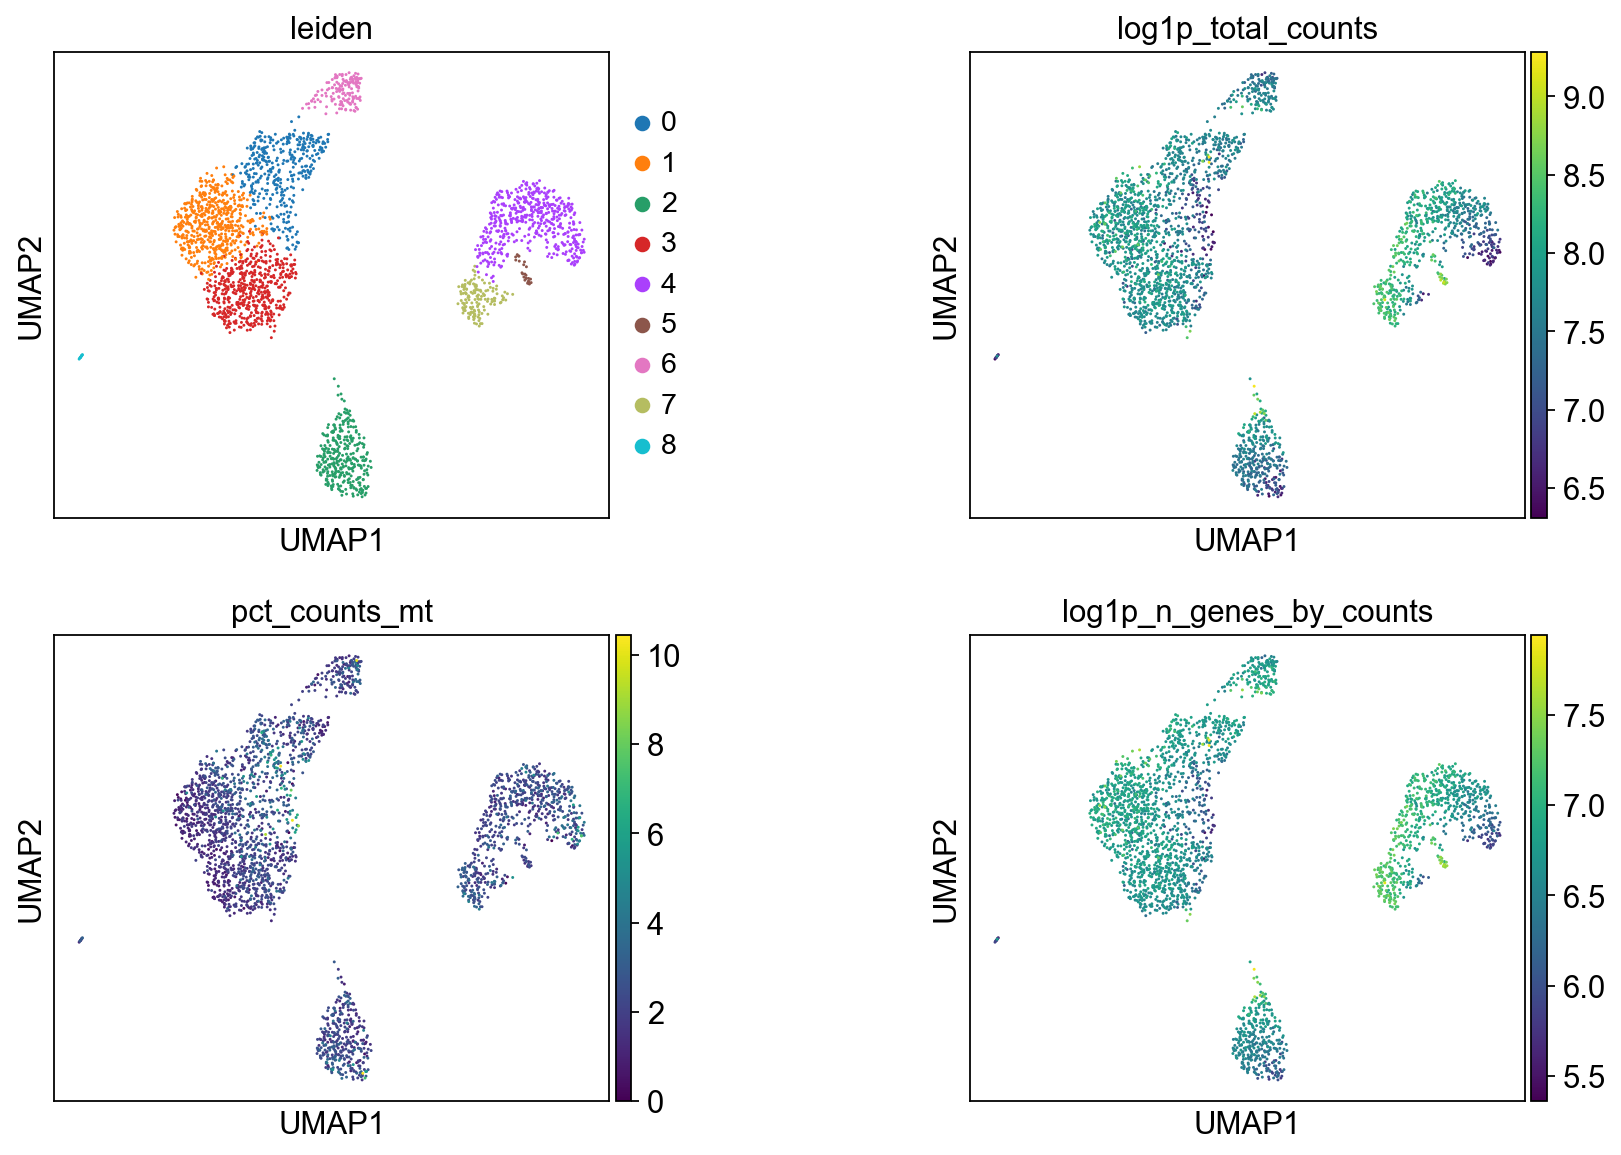

In [14]:
sc.pl.umap(
    adata,
    color=["leiden", "log1p_total_counts", "pct_counts_mt", "log1p_n_genes_by_counts"],
    wspace=0.5,
    ncols=2,
    size=7,
)

### 7. Marker Gene and Annotation

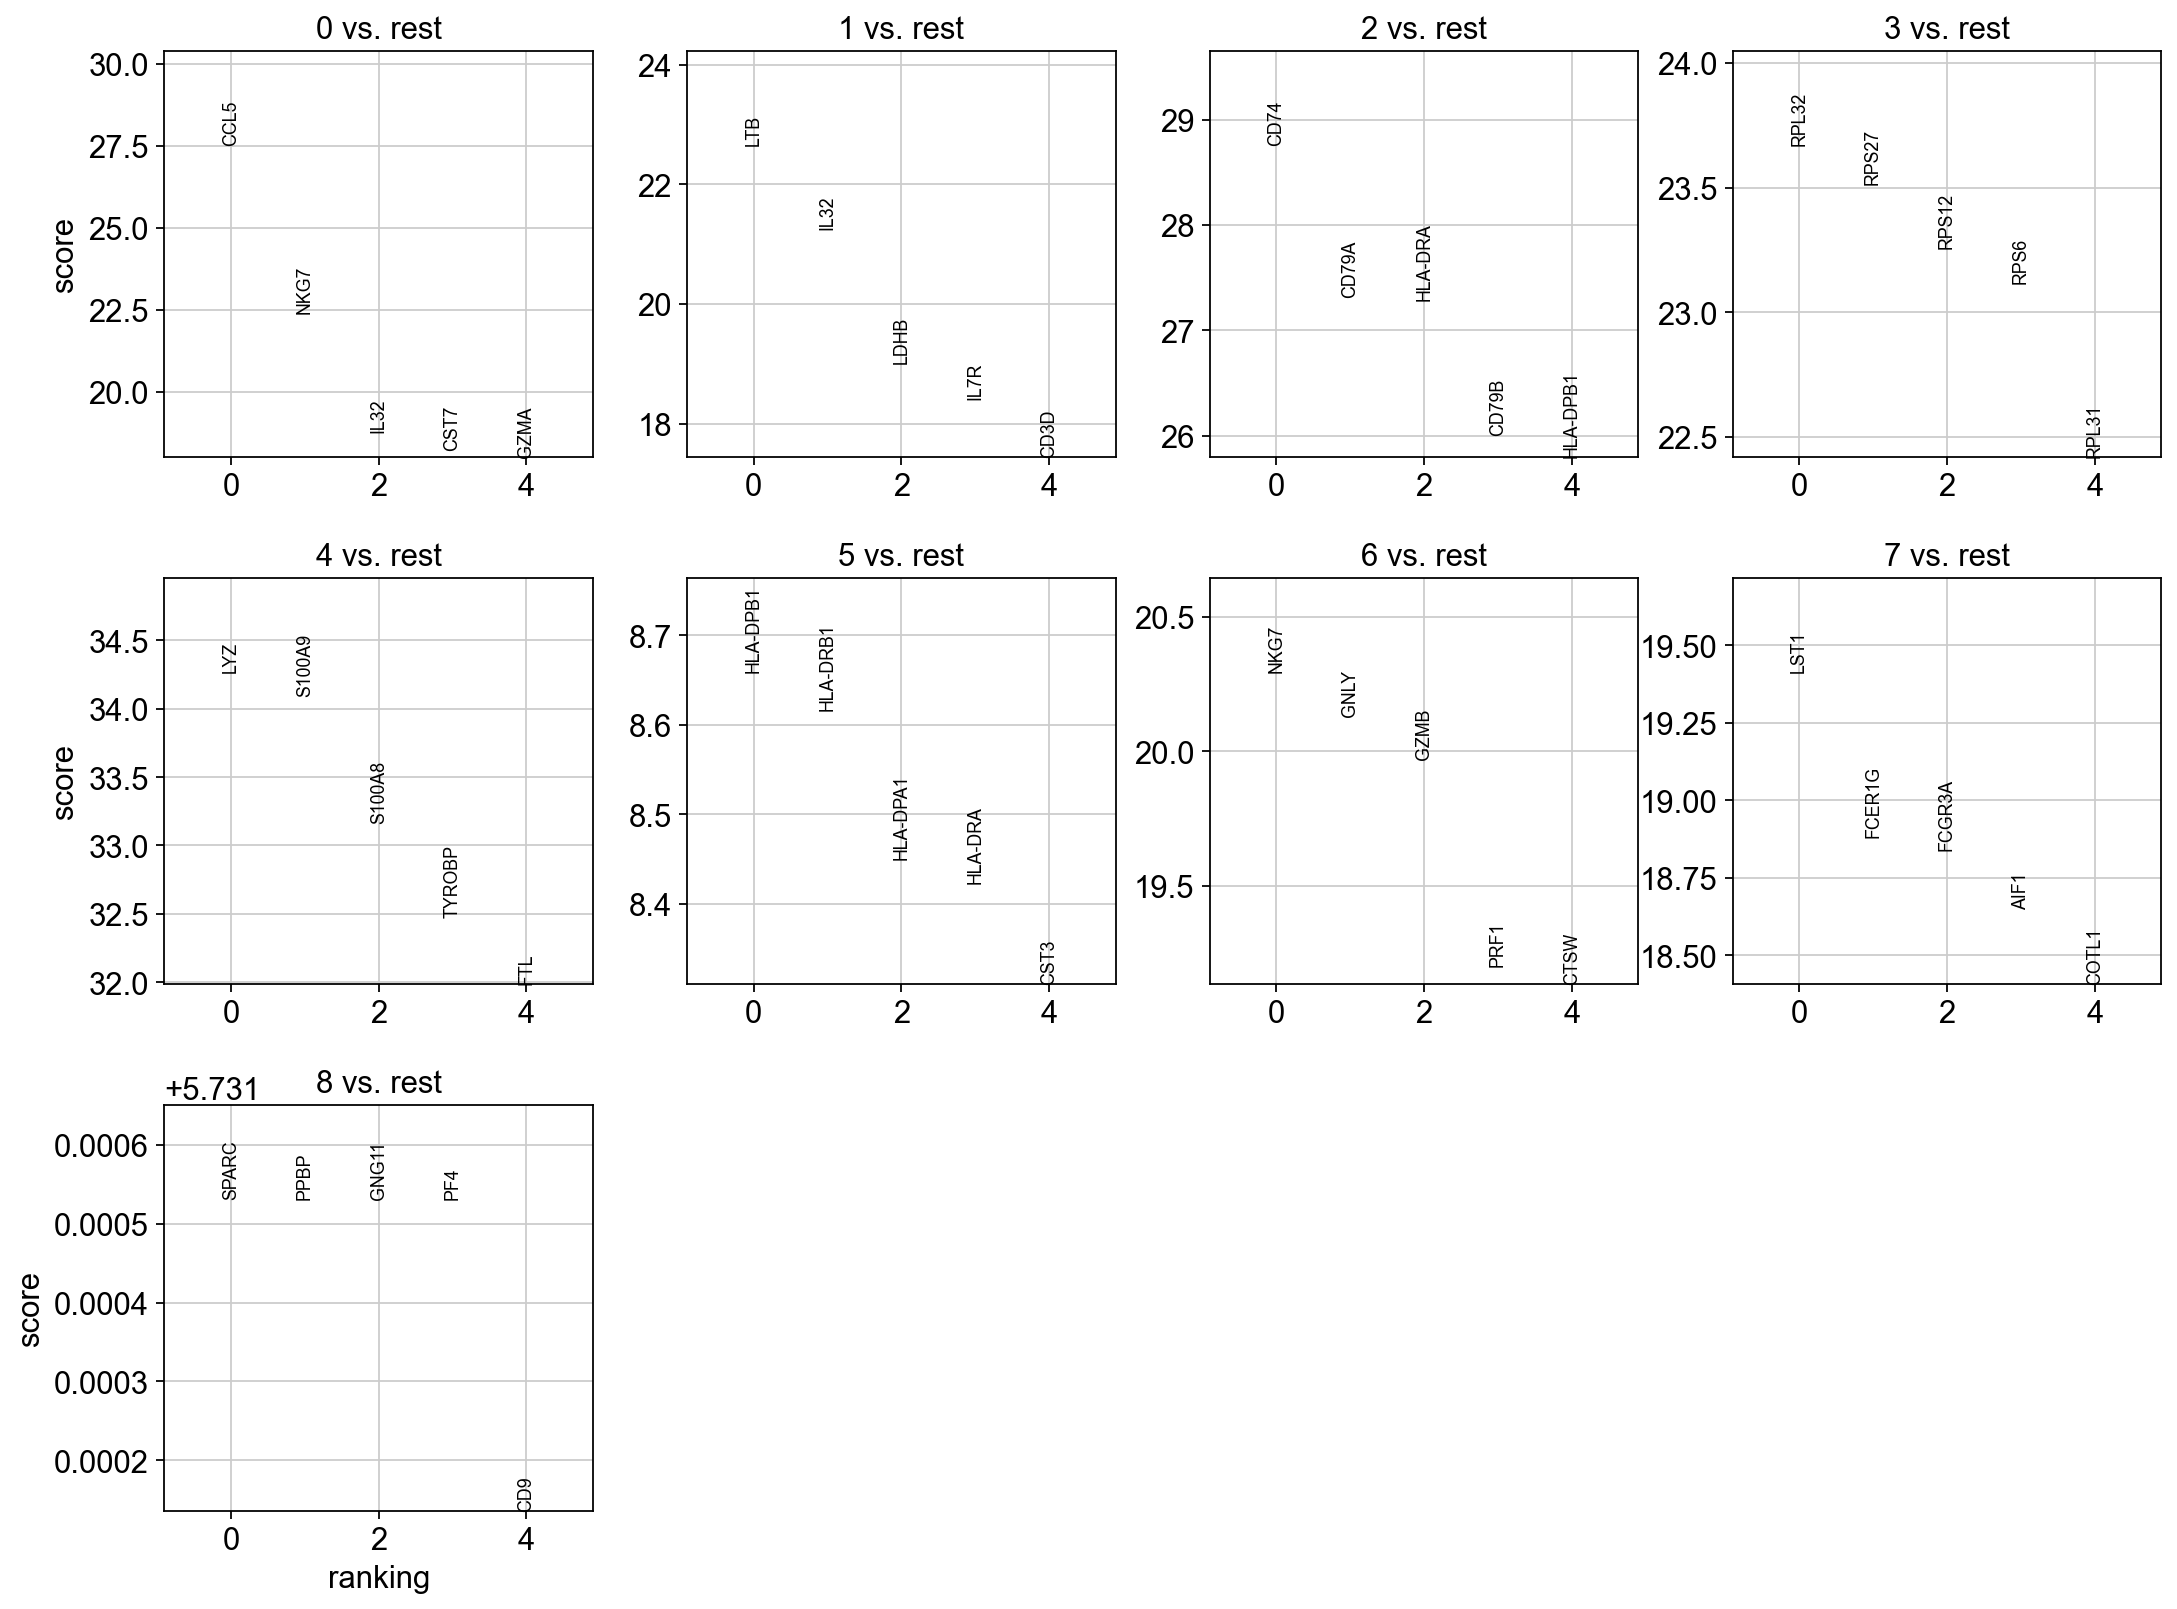

In [15]:
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=5, sharey=False)


In [16]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7,8
0,CCL5,LTB,CD74,RPL32,LYZ,HLA-DPB1,NKG7,LST1,SPARC
1,NKG7,IL32,CD79A,RPS27,S100A9,HLA-DRB1,GNLY,FCER1G,PPBP
2,IL32,LDHB,HLA-DRA,RPS12,S100A8,HLA-DPA1,GZMB,FCGR3A,GNG11
3,CST7,IL7R,CD79B,RPS6,TYROBP,HLA-DRA,PRF1,AIF1,PF4
4,GZMA,CD3D,HLA-DPB1,RPL31,FTL,CST3,CTSW,COTL1,CD9


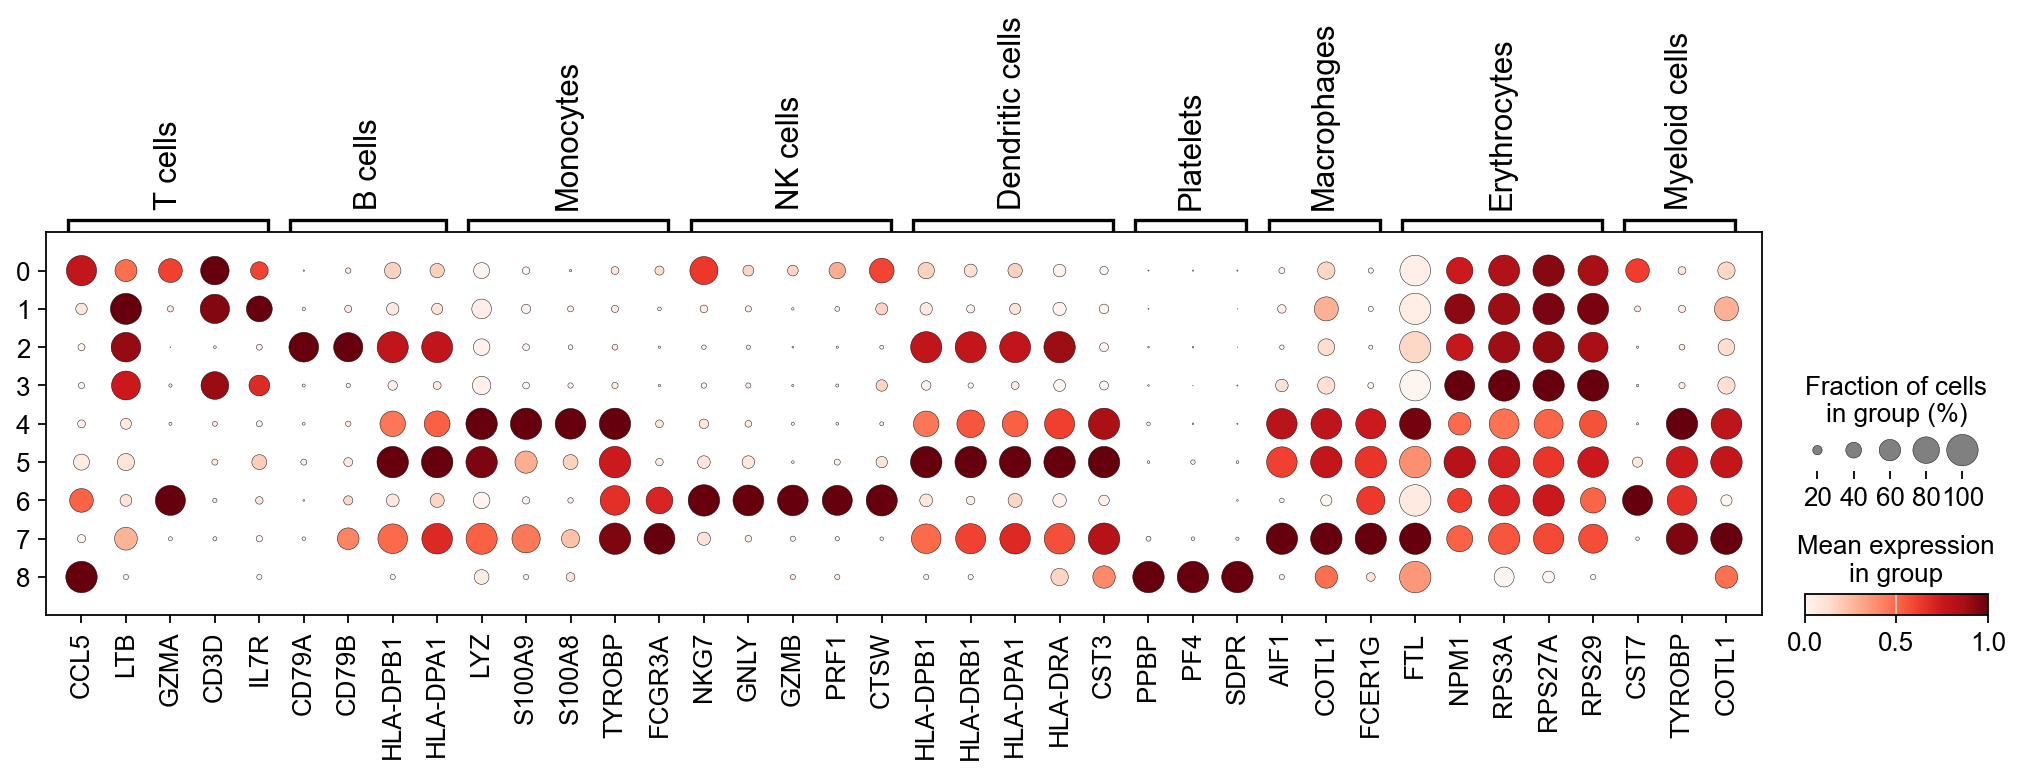

In [17]:
# should start with above marker genes to form the dictionary
# and then by looking at the dotplot, label cluster witeh broad lineages.
marker_genes = {
    "T cells": ["CCL5", "LTB", "GZMA", "CD3D", "IL7R"],
    "B cells": ["CD79A", "CD79B", "HLA-DPB1", "HLA-DPA1"],
    "Monocytes": ["LYZ", "S100A9", "S100A8", "TYROBP", "FCGR3A"],
    "NK cells": ["NKG7", "GNLY", "GZMB", "PRF1", "CTSW"],
    "Dendritic cells": ["HLA-DPB1", "HLA-DRB1", "HLA-DPA1", "HLA-DRA", "CST3"],
    "Platelets": ["PPBP", "PF4", "SDPR"],
    "Macrophages": ["AIF1", "COTL1", "FCER1G"],
    "Erythrocytes": ["FTL", "NPM1", "RPS3A", "RPS27A", "RPS29"],
    "Myeloid cells": ["CST7", "TYROBP", "COTL1"],
}

sc.pl.dotplot(adata, marker_genes, groupby="leiden", standard_scale="var")

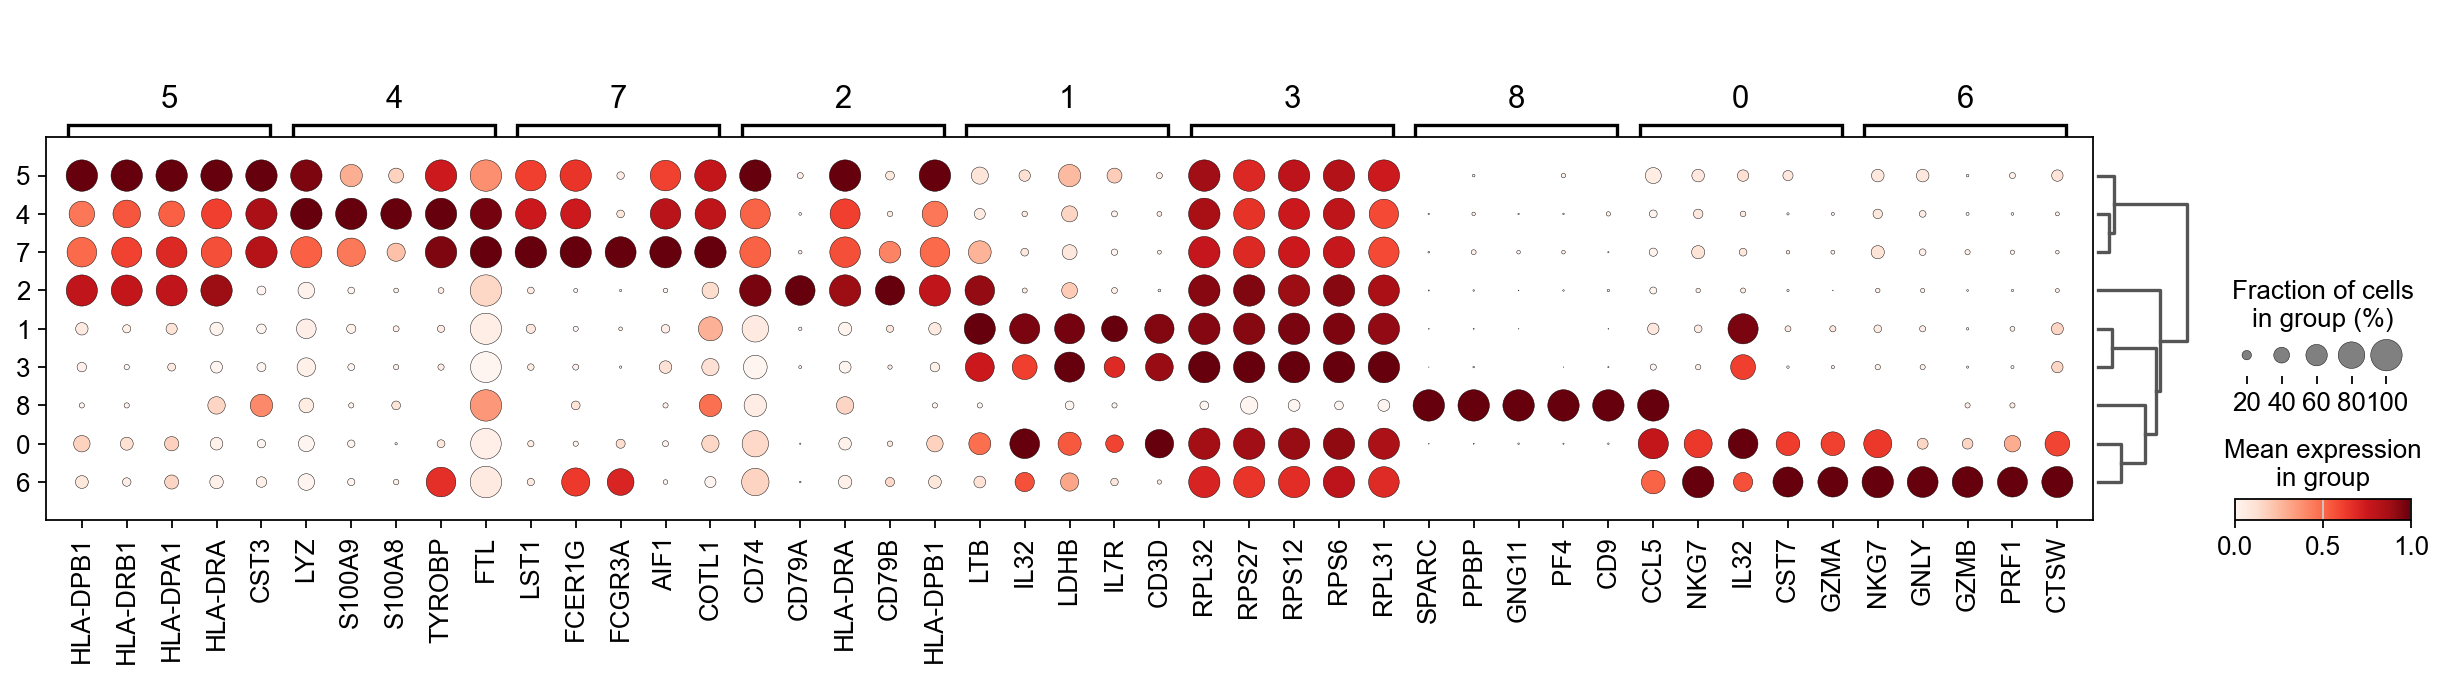

In [18]:
sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5
)


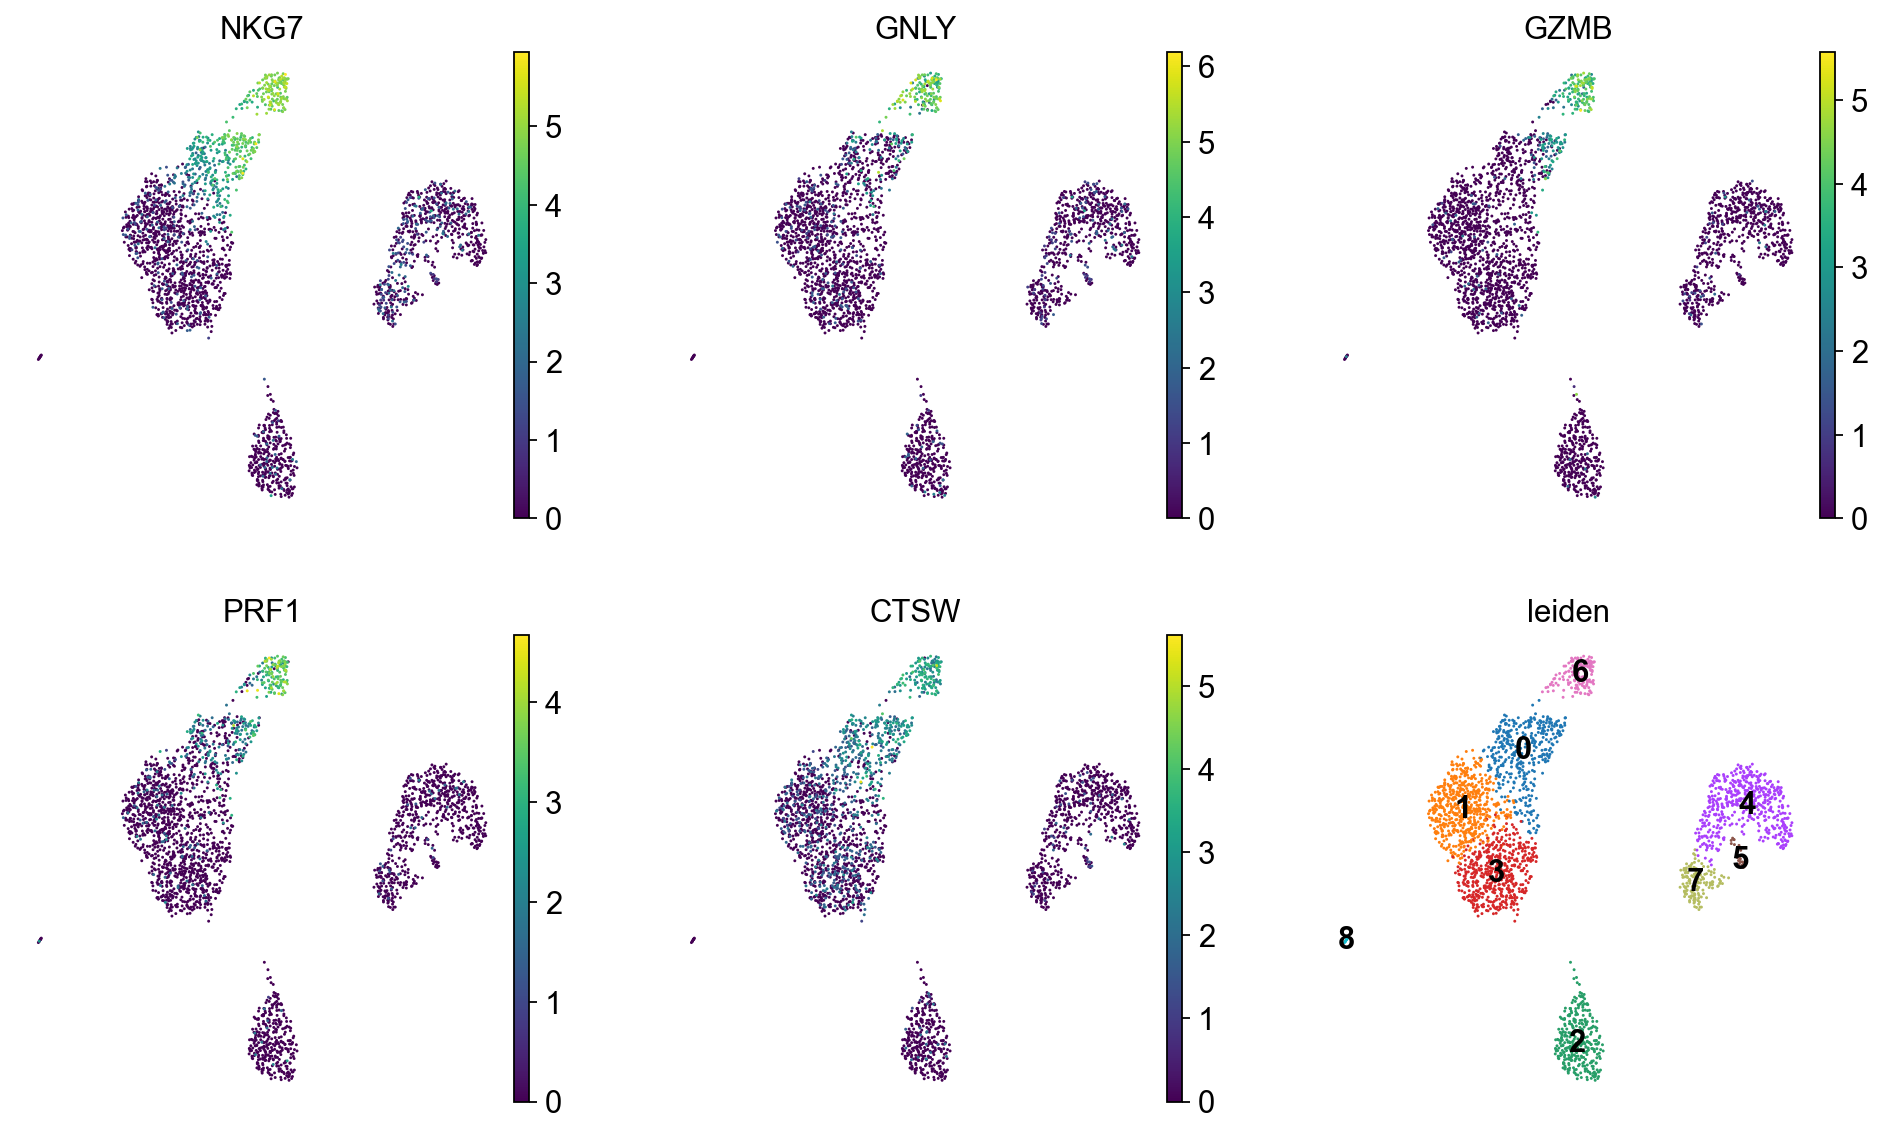

In [19]:
dc_cluster_genes = sc.get.rank_genes_groups_df(adata, group="6").head(5)["names"]
sc.pl.umap(
    adata,
    color=[*dc_cluster_genes, "leiden"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
    size = 7,
)